In [1]:
import pandas as pd
import numpy as np
from sklearn import ensemble, feature_extraction, preprocessing
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from numpy.random import rand
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(context="poster", style="dark")

import operator

In [2]:
def multiclass_log_loss(y_true, y_pred, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    https://www.kaggle.com/wiki/MultiClassLogLoss

    Parameters
    ----------
    y_true : array, shape = [n_samples]
            true class, intergers in [0, n_classes - 1)
    y_pred : array, shape = [n_samples, n_classes]

    Returns
    -------
    loss : float
    """
    predictions = np.clip(y_pred, eps, 1 - eps)

    # normalize row sums to 1
    predictions /= predictions.sum(axis=1)[:, np.newaxis]

    actual = np.zeros(y_pred.shape)
    n_samples = actual.shape[0]
    actual[np.arange(n_samples), y_true.astype(int)] = 1
    vectsum = np.sum(actual * np.log(predictions))
    loss = -1.0 / n_samples * vectsum
    return loss

In [3]:
# import data
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
sample = pd.read_csv('data/sampleSubmission.csv')

# drop ids and get labels
labels = train_df.target.values
train_df = train_df.drop('id', axis=1)
train = train_df.drop('target', axis=1)
test = test_df.drop('id', axis=1)

# transform counts to TFIDF features
tfidf = feature_extraction.text.TfidfTransformer()
train = tfidf.fit_transform(train).toarray()
test = tfidf.transform(test).toarray()

# encode labels 
lbl_enc = preprocessing.LabelEncoder()
labels = lbl_enc.fit_transform(labels)

print('train shape: ', np.shape(train))

train shape:  (61878, 93)


In [4]:
del(train_df)
del(test_df)

In [5]:
def test_model(X, y, model):
    import time

    # print("start fitting... ", time.ctime().split()[3])
    # model.fit(train_lda, labels)
    # print("done fitting... ", time.ctime().split()[3])

    print('start cross-validation... ', time.ctime().split()[3])
    scores = cross_validation.cross_val_score(gbc_param_lda, train_lda, labels, cv=5, n_jobs=-1, )
    print("500_pca: 0.813568454693; 100_pca: 0.802369071983, 100_all: 0.80291819865, 1k_scaled: 0.816218868426")
    print("mean score: ", np.mean(scores))

In [6]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [7]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()

# train = np.log10(train+1)
# test = np.log10(test+1)

X_scaler.fit(train)

train_scaled = X_scaler.transform(train)
test_scaled = X_scaler.transform(test)

# train_scaled

In [8]:
def make_newX(X):
    cols = np.array([34, 48, 16, 39, 62, 68, 60, 67, 22]) - 1
#     cols = np.array([24, 13, 66, 85, 33, 23, 47, 39, 87, 63]) - 1
    multi = X[:, cols]

    new_X = X

    for i in range(multi.shape[1]):
        for j in range(multi.shape[1]):
            if i>j:
                new_X = np.concatenate((new_X, (np.reshape((multi[:,1]*X[:,1]), [X.shape[0],1]))), axis=1)
                
    return new_X

In [9]:
new_train = make_newX(train)
new_test = make_newX(test)
new_train.shape

(61878, 129)

In [10]:
def make_XY(train, labels):
    X_train, X_valid, y_train, y_valid = train_test_split(train, labels, train_size=0.90)
#     del(new_train)
#     del(labels)
    
    return X_train, X_valid, y_train, y_valid

In [11]:
np.shape(test_scaled)

(144368, 93)

In [11]:
from sklearn.decomposition import RandomizedPCA

pca = RandomizedPCA(n_components=1, whiten=False)
pca.fit(train_scaled)
# plt.plot(pca.components_[0,:])
train_fac = pca.transform(train_scaled)
test_fac = pca.transform(test_scaled)
np.shape(train_fac)

train_pca = np.concatenate((train_scaled, train_fac), axis=1)
test_pca = np.concatenate((test_scaled, test_fac), axis=1)
np.shape(train_pca)

(61878, 94)

In [16]:
train_fac.shape

(61878, 1)

In [10]:
np.shape(train)

(61878, 93)

In [152]:
from sklearn.lda import LDA

lda = LDA(n_components=9)
lac_train = lda.fit(train_scaled, labels).transform(train_scaled)
lac_test = lda.fit(train_scaled, labels).transform(test_scaled)

train_lda = np.concatenate((train_scaled, lac_train), axis=1)
test_lda = np.concatenate((test_scaled, lac_test), axis=1)
np.shape(train_lda)
# np.shape(labels)
# np.shape(lac_train)

(61878, 101)

In [32]:
lac_train[:,7]

array([-0.06056113,  0.10865195, -0.33021717, ..., -0.92090514,
        1.81554271, -0.50119047])

In [30]:
colors = ['red', 'green', 'blue', 'orange', 'black', 'purple', 'yellow', 'grey', 'magenta']

colors_labels = []

# for i in range(len(labels)):
#     color_labels.append(colors[labels[i]])

color_labels = np.array(colors)[labels]

    
# color_labels

In [31]:
from sklearn.decomposition import FastICA

ica = FastICA()
Z = ica.fit_transform(train_scaled)

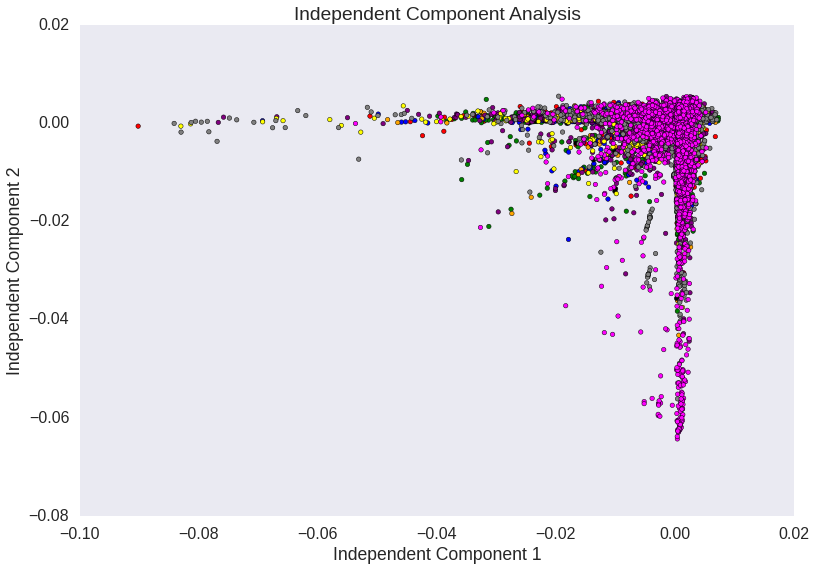

In [32]:
plt.scatter(Z.T[0], Z.T[1], c=color_labels);             #, edgecolor='w', s=50
sns.axlabel('Independent Component 1', 'Independent Component 2');
plt.title('Independent Component Analysis');

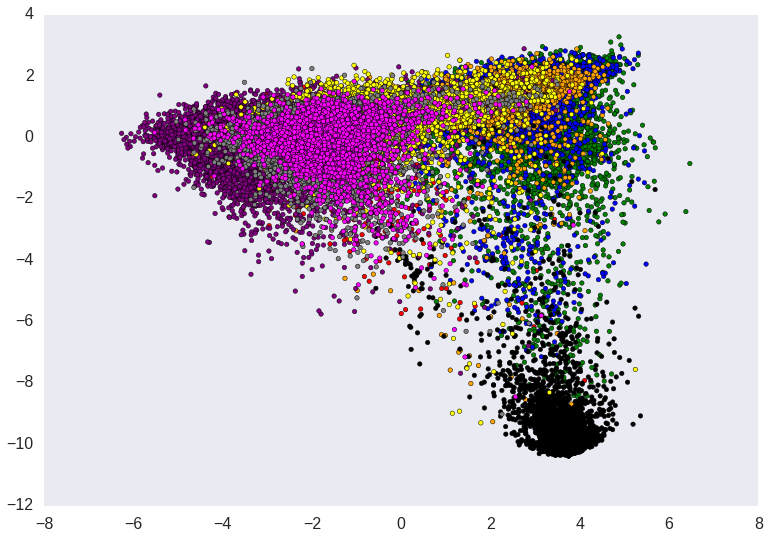

In [160]:
# for i in range(len(labels)):
plt.scatter(lac_train[:,0], lac_train[:,1], c = color_labels)

In [61]:
X_train, X_valid, y_train, y_valid = make_XY(train_c, labels)

from sklearn.naive_bayes import GaussianNB
gauss_nb = GaussianNB()

gauss_nb.fit(X_train, y_train)
print("done fitting")

gauss_nb.score(X_valid, y_valid)

done fitting


0.48989980607627664

In [16]:
scores = cross_validation.cross_val_score(gauss_nb, new_train, labels, cv=5, n_jobs=-1)
print(0.691958421645, 0.698438779249, 0.69858442809)
print("average score: ", np.mean(scores))

0.691958421645 0.698438779249 0.69858442809
average score:  0.505674050316


In [47]:
from sklearn.svm import LinearSVC

line_svc = LinearSVC()
line_svc.fit(train_scaled, labels)

print("done")

done


In [48]:
scores = cross_validation.cross_val_score(line_svc, train_scaled, labels, cv=5, n_jobs=-1)
print(0.691958421645, 0.698438779249, 0.69858442809)
print("average score: ", np.mean(scores))

0.691958421645 0.698438779249 0.69858442809
average score:  0.755195797857


In [51]:
from sklearn.svm import SVC

svc = SVC(verbose=1, probability=True, degree=7)
svc.fit(X=train_scaled, y=labels)
print("done fitting")

scores = cross_validation.cross_val_score(svc, train_scaled, labels, cv=2, n_jobs=-1)
print(0.813568454693)
print("average score: ", np.mean(scores))

[LibSVM]done fitting
0.813568454693
average score:  0.7934322921


In [ ]:
from sklearn.grid_search import GridSearchCV

param_grid = {'learning_rate': [0.1, 0.05],
              'max_depth': [8, 15, 20],
              'min_samples_leaf': [5, 10, 20],
              }
 
est = ensemble.GradientBoostingClassifier(n_estimators=1000, verbose=2, random_state=10)
print("now now")
# this may take awhile
gs_cv = GridSearchCV(est, param_grid, n_jobs=-1, verbose=2).fit(train_scaled, labels)

now now
Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [ ]:
print("results:'")

# best hyperparameter setting
gs_cv.best_params_

In [48]:
from sklearn.ensemble import GradientBoostingClassifier

# X_train, X_valid, y_train, y_valid = make_XY(new_train, labels)

# print("start training")

params = {'max_depth':20, 'subsample':0.5, 'verbose':1, 'random_state':0,
        'min_samples_split':20, 'min_samples_leaf':20, 'max_features':'sqrt',
        'n_estimators': 750, 'learning_rate': 0.01}

import time

# print("start fitting... ", time.ctime().split()[3])
gbc = GradientBoostingClassifier()
# # gbc.fit(X_train, y_train)
# print("done fitting... ", time.ctime().split()[3])

print("start cross-validation... ", time.ctime().split()[3])
scores = cross_validation.cross_val_score(gbc, new_train, labels, cv=6, n_jobs=-1)
print("500_pca: 0.813568454693; 100_pca: 0.802369071983, 100_all: 0.80291819865, 1k_scaled: 0.816218868426")
print("done cross-validation... ", time.ctime().split()[3])

start cross-validation...  02:41:26
500_pca: 0.813568454693; 100_pca: 0.802369071983, 100_all: 0.80291819865, 1k_scaled: 0.816218868426
done cross-validation...  04:34:57
      Iter       Train Loss      OOB Improve   Remaining Time 
      Iter       Train Loss      OOB Improve   Remaining Time 
      Iter       Train Loss      OOB Improve   Remaining Time 
      Iter       Train Loss      OOB Improve   Remaining Time 
      Iter       Train Loss      OOB Improve   Remaining Time 
      Iter       Train Loss      OOB Improve   Remaining Time 
         1       54088.9585        1016.1178           76.99m         1       54095.6899        1015.2583           77.46m         1       54084.0611        1023.6728           79.48m         1       54059.6350        1057.7790           77.42m         1       54079.3128        1024.2928           55.35m         1       54079.1722        1037.5065           57.96m





         2       53044.0996         990.5816           74.73m         2       5

In [13]:
db_labels = np.load('dbscan_labels.npy')

train_clusters = np.reshape(db_labels[:61878], [61878, 1])
train_c = np.concatenate((new_train, train_clusters), axis=1)
test_clusters = np.reshape(db_labels[61878:], [new_test.shape[0], 1])
test_c = np.concatenate((new_test, test_clusters), axis=1)

In [46]:
# labels_class0 = (labels == 0)
labels_class_0 = lbl_enc.fit_transform((labels == 0))
labels_class_0

array([1, 1, 1, ..., 0, 0, 0])

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(train_c, labels, train_size=0.90)

def train_model(X, y, n_est=700):

    params = {'max_depth':20, 'subsample':0.5, 'verbose':1, 'random_state':0,
            'min_samples_split':10, 'min_samples_leaf':10, 'max_features':'sqrt',
            'n_estimators': n_est, 'learning_rate': 0.01}

    import time

    print("start fitting... ", time.ctime().split()[3])
    gbc = GradientBoostingClassifier(**params)

    gbc.fit(X, y)

    print("finished fitting...", time.ctime().split()[3])
    
    return gbc

In [14]:
train_c.shape

(61878, 130)

In [31]:
train_lasagne_labels = np.load('train_predicted.npy')
test_lasagne_labels = np.load('test_predicted.npy')

test_lasagne_labels.shape

(144368,)

In [32]:
train_lasagne_labels = np.reshape(train_lasagne_labels, [61878,1])
test_lasagne_labels = np.reshape(test_lasagne_labels, [144368,1])

In [39]:
train_lasagne = np.concatenate([train_c, train_lasagne_labels], axis=1)
test_lasagne = np.concatenate([test_c, test_lasagne_labels], axis=1)

train_lasagne.shape

(61878, 131)

In [20]:
# X_train, X_valid, y_train, y_valid = train_test_split(train_lasagne, labels, train_size=1.00)

gbc_700 = train_model(train_c, labels)

start fitting...  19:30:48
      Iter       Train Loss      OOB Improve   Remaining Time 
         1       64810.0872        1272.8078          113.74m
         2       63519.4935        1227.6615          121.66m
         3       62249.6062        1184.6821          123.15m
         4       61061.0216        1089.7905          128.09m
         5       59936.7737        1028.8214          132.91m
         6       58853.0023         988.8955          133.76m
         7       57847.5424         953.2897          135.31m
         8       56861.1074         914.9200          135.90m
         9       55920.3055         871.0816          136.98m
        10       54986.7128         846.2857          137.34m
        20       47295.9297         611.6483          135.66m
        30       41502.2500         471.8748          134.03m
        40       36756.4019         374.6257          130.41m
        50       32946.1005         302.3801          127.69m
        60       29729.7542         255.51

In [22]:
import time

prob_array = gbc_700.predict_proba(test_c)

print(time.ctime().split()[3])

# create submission file
preds = pd.DataFrame(prob_array, index=sample.id.values, columns=sample.columns[1:])
preds.to_csv('gbc_700_min_split-leaf-10_5-17-15.csv', index_label='id')
print("done predicting!")

21:33:32
done predicting!


In [44]:
gbc_las.feature_importances_

array([ 0.00727261,  0.00188875,  0.00384846,  0.00444153,  0.00251947,
        0.00101791,  0.00455736,  0.01720541,  0.01388718,  0.0061302 ,
        0.01089436,  0.00246969,  0.00742233,  0.02673304,  0.02118185,
        0.01661772,  0.01453194,  0.00860129,  0.00242414,  0.00810214,
        0.00340753,  0.00985449,  0.00506004,  0.02808127,  0.03456407,
        0.01155719,  0.00320787,  0.00273217,  0.00593299,  0.00611616,
        0.00145008,  0.01626528,  0.01748792,  0.04596686,  0.00652313,
        0.01773598,  0.0085459 ,  0.00746779,  0.01377461,  0.02869734,
        0.00829214,  0.01725256,  0.01574724,  0.00747955,  0.00439708,
        0.00291872,  0.00740591,  0.02606016,  0.00306096,  0.01157014,
        0.00116593,  0.00230448,  0.01425241,  0.01295885,  0.00851793,
        0.01129098,  0.0075274 ,  0.00353292,  0.0096929 ,  0.01581916,
        0.00172911,  0.02075764,  0.00289565,  0.0208789 ,  0.0056224 ,
        0.01170524,  0.03376664,  0.01088781,  0.00594811,  0.01

In [45]:
import time

prob_array = gbc_las.predict_proba(test_lasagne)

print(time.ctime().split()[3])

# create submission file
preds = pd.DataFrame(prob_array, index=sample.id.values, columns=sample.columns[1:])
preds.to_csv('gbc_from_lasagne_10-12-15.csv', index_label='id')
print("done predicting!")

01:04:04
done predicting!


In [47]:
gbc_train_predicted = gbc_las.predict(train_lasagne)
gbc_test_predicted = gbc_las.predict(test_lasagne)

np.save('gbc_train_predicted.npy', gbc_train_predicted)
np.save('gbc_test_predicted.npy', gbc_test_predicted)

In [50]:
gbc_las_1500 = train_model(train_lasagne, labels, n_est=1500)

prob_array = gbc_las_1500.predict_proba(test_lasagne)

print(time.ctime().split()[3])

# create submission file
preds = pd.DataFrame(prob_array, index=sample.id.values, columns=sample.columns[1:])
preds.to_csv('gbc_from_lasagne_10-12-15_1500-est.csv', index_label='id')
print("done predicting!")

start fitting...  01:37:05
      Iter       Train Loss      OOB Improve   Remaining Time 
         1       64942.1711        1227.1138          148.93m
         2       63793.2947        1112.0024          164.25m
         3       62629.0761        1099.8511          167.73m
         4       61522.3252        1046.0698          173.32m
         5       60426.7888        1038.2547          172.55m
         6       59411.5617         955.9442          174.66m
         7       58454.0895         929.8865          175.68m
         8       57519.5145         880.7890          176.41m
         9       56631.8113         855.3921          178.15m
        10       55745.9115         822.9966          182.08m
        20       48347.9010         619.3445          213.28m
        30       42788.9470         476.5769          247.06m
        40       38271.8799         373.1314          265.33m
        50       34644.8040         307.8344          273.70m
        60       31564.8432         257.05

In [49]:
from sklearn.metrics import confusion_matrix

confused_gbc = confusion_matrix(y_valid, gbc_0.predict(X_valid))
confused_gbc

array([[603,   2],
       [  9,   5]])

In [50]:
gbc_0.predict(X_valid)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0,

In [ ]:
confused_weights = [ confused_gbc[i,i] / np.sum(confused_gbc[i]) for i in range(confused_gbc.shape[0]) ]

In [ ]:
confused_weights

In [48]:
feat_imports = dict(list(enumerate(gbc.feature_importances_)))
import operator
sort = sorted(feat_imports.items(), key=operator.itemgetter(1), reverse=True)

print("(24, 13, 66, 85, 33, 23, 47, 39, 87, 63)")

list(zip(*sort))[0][:10]

(24, 13, 66, 85, 33, 23, 47, 39, 87, 63)


(24, 66, 13, 85, 33, 23, 47, 39, 87, 63)

In [51]:
test_clusters = np.reshape(db_labels[61878:], [new_test.shape[0], 1])
test_c = np.concatenate((new_test, test_clusters), axis=1)

prob_array = gbc.predict_proba(test_c)

print(time.ctime().split()[3])

# create submission file
preds = pd.DataFrame(prob_array, index=sample.id.values, columns=sample.columns[1:])
preds.to_csv('gbc_dbscan.csv', index_label='id')
print("done predicting!")

print(new_test.shape)
print(db_labels[61878:].shape)

12:57:13
done predicting!
(144368, 129)
(144368,)


In [46]:
import operator
sort = sorted(feat_imports.items(), key=operator.itemgetter(1), reverse=True)

print("(24, 13, 66, 85, 33, 23, 47, 39, 87, 63)")

list(zip(*sort))[0][:10]

(24, 13, 66, 85, 33, 23, 47, 39, 87, 63)


(24, 13, 66, 85, 33, 23, 47, 39, 87, 63)

In [64]:
params = {'max_depth':20, 'subsample':0.5, 'verbose':2, 'random_state':0,
        'min_samples_split':20, 'min_samples_leaf':20, 'max_features':'sqrt',
        'n_estimators': 1500, 'learning_rate': 0.01}

import time

print("start fitting... ", time.ctime().split()[3])
gbc = GradientBoostingClassifier(**params)

gbc.fit(new_train, labels)

start fitting...  01:09:11
      Iter       Train Loss      OOB Improve   Remaining Time 
         1       64927.1190        1236.3171          131.24m
         2       63768.7663        1115.0854          143.98m
         3       62610.4007        1095.9714          152.47m
         4       61506.6018        1032.6611          157.82m
         5       60427.4965        1014.7776          158.88m
         6       59389.5608         982.7956          164.14m
         7       58400.5856         957.3982          163.74m
         8       57452.3407         896.0371          163.75m
         9       56572.6475         850.7374          165.16m
        10       55700.9993         806.2257          167.98m
        11       54868.2429         800.6981          168.52m
        12       54036.7528         765.3916          169.19m
        13       53282.0235         741.8404          169.28m
        14       52536.2006         719.0508          169.48m
        15       51732.4635         681.87

GradientBoostingClassifier(init=None, learning_rate=0.01, loss='deviance',
              max_depth=20, max_features='sqrt', max_leaf_nodes=None,
              min_samples_leaf=20, min_samples_split=20, n_estimators=1500,
              random_state=0, subsample=0.5, verbose=2, warm_start=False)

In [62]:
X_train, X_valid, y_train, y_valid = train_test_split(new_train, labels, train_size=0.85)

params = {'max_depth':20, 'subsample':0.5, 'verbose':2, 'random_state':0,
        'min_samples_split':20, 'min_samples_leaf':20, 'max_features':'sqrt',
        'n_estimators': 3000, 'learning_rate': 0.01}

import time

print("start fitting... ", time.ctime().split()[3])
gbc = GradientBoostingClassifier(**params)

gbc.fit(X_train, y_train)

print("finished fitting...", time.ctime().split()[3])

multiclass_log_loss(y_valid, gbc.predict_proba(X_valid))

start fitting...  21:53:13
      Iter       Train Loss      OOB Improve   Remaining Time 
         1       55220.1726        1031.8680          206.77m
         2       54215.0496         948.3642          228.32m
         3       53269.5553         904.8071          236.72m
         4       52342.1625         893.3849          240.45m
         5       51422.6302         852.0539          244.11m
         6       50519.3108         834.6084          243.09m
         7       49706.8361         784.3434          248.18m
         8       48932.7573         762.0961          247.97m
         9       48172.5490         742.3291          249.23m
        10       47393.1571         712.1916          248.69m
        11       46716.3355         682.2348          248.92m
        12       45998.0280         652.2136          249.41m
        13       45314.0786         620.2597          250.21m
        14       44717.7649         598.4236          250.21m
        15       44038.0469         602.50

0.51808948085899587

In [ ]:
gbc_n = GradientBoostingClassifier(**params)
gbc_n.fit(new_train, labels)

In [ ]:
bad_cols = np.array([82, 48, 49]) - 1
better_train = np.delete(new_train, bad_cols, axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(train_scaled, labels, train_size=0.85)

params = {'max_depth':20, 'subsample':0.5, 'verbose':2, 'random_state':0,
        'min_samples_split':20, 'min_samples_leaf':20, 'max_features':'sqrt',
        'n_estimators': 1500, 'learning_rate': 0.01}

import time

print("start fitting... ", time.ctime().split()[3])
gbc_better = GradientBoostingClassifier(**params)

gbc_better.fit(X_train, y_train)

print("finished fitting...", time.ctime().split()[3])

multiclass_log_loss(y_valid, gbc_better.predict_proba(X_valid)) # 0.47095760233899847 -> 0.45746

start fitting...  21:40:46
      Iter       Train Loss      OOB Improve   Remaining Time 
         1       55177.3459        1072.7685          200.64m
         2       54107.0955        1019.2827          214.79m
         3       53119.8186         936.5195          223.76m
         4       52172.5522         905.6196          231.77m
         5       51272.6099         863.5075          233.77m
         6       50425.6959         821.7342          238.30m
         7       49568.7958         796.2516          238.95m
         8       48727.5870         754.6337          244.05m
         9       48017.3386         727.4447          248.70m
        10       47256.8089         707.5418          251.05m
        11       46535.7771         665.4222          251.06m
        12       45835.3536         642.1119          251.77m
        13       45147.9147         639.2944          251.15m
        14       44546.2796         617.7951          250.61m
        15       43891.1221         588.20

In [61]:
X_train, X_valid, y_train, y_valid = train_test_split(new_train, labels, train_size=0.85)

params = {'max_depth':40, 'subsample':0.5, 'verbose':2, 'random_state':0,
        'min_samples_split':20, 'min_samples_leaf':20, 'max_features':'sqrt',
        'n_estimators': 1500, 'learning_rate': 0.01}

import time

print("start fitting... ", time.ctime().split()[3])
gbc = GradientBoostingClassifier(**params)

gbc.fit(X_train, y_train)

print("finished fitting...", time.ctime().split()[3])

multiclass_log_loss(y_valid, gbc.predict_proba(X_valid))

start fitting...  14:12:09
      Iter       Train Loss      OOB Improve   Remaining Time 
         1       55210.9681        1042.9451          132.27m
         2       54181.1222         980.1250          155.28m
         3       53208.1198         902.6489          166.24m
         4       52268.5412         901.5622          171.87m
         5       51368.2175         864.8578          175.93m
         6       50480.5683         835.9490          177.98m
         7       49642.5128         790.1967          179.70m
         8       48822.2779         760.3638          181.01m
         9       48049.5753         736.0406          181.87m
        10       47332.7523         706.1972          181.34m
        11       46534.6986         672.0382          182.10m
        12       45931.0868         654.8648          182.70m
        13       45225.8894         638.8078          183.12m
        14       44575.9395         601.5701          183.36m
        15       43984.7179         594.60

0.50208156614534361

In [44]:
X_train, X_valid, y_train, y_valid = make_XY(new_train, labels)

params = {'max_depth':40, 'subsample':0.5, 'verbose':1, 'random_state':0,
        'min_samples_split':20, 'min_samples_leaf':20, 'max_features':'sqrt',
        'n_estimators': 1500, 'learning_rate': 0.01}

import time

print("start fitting... ", time.ctime().split()[3])
gbc_40 = GradientBoostingClassifier(**params)

gbc_40.fit(X_train, y_train)

print("done fitting")

multiclass_log_loss(y_valid, gbc_40.predict_proba(X_valid))

start fitting...  09:37:46
      Iter       Train Loss      OOB Improve   Remaining Time 
         1       51952.4850         978.8954          116.81m
         2       50989.6518         928.1647          137.04m
         3       50089.9231         847.7486          145.60m
         4       49184.2412         858.1940          150.79m
         5       48347.6783         777.7057          154.93m
         6       47519.3820         783.8736          157.31m
         7       46745.0130         731.3194          159.06m
         8       45965.1301         697.8011          160.11m
         9       45295.2323         683.6799          161.13m
        10       44621.6961         652.5207          161.59m
        20       38705.6327         463.7340          167.46m
        30       34220.4218         372.0844          169.76m
        40       30587.3694         300.8916          170.12m
        50       27674.9374         246.1923          170.50m
        60       25217.1089         203.05

0.52200125022283383

In [ ]:
X_train_s, X_valid_s, y_train_s, y_valid_s = make_XY(train, labels)

params = {'max_depth':20, 'subsample':0.5, 'verbose':1, 'random_state':0,
        'min_samples_split':20, 'min_samples_leaf':20, 'max_features':'sqrt',
        'n_estimators': 1500, 'learning_rate': 0.01}

import time

print("start fitting... ", time.ctime().split()[3])
gbc_s = GradientBoostingClassifier(**params)

gbc_s.fit(X_train_s, y_train_s)

multiclass_log_loss(y_valid, gbc_s.predict_proba(X_valid_s))

In [54]:
cols = np.array([34, 48, 16, 39, 62, 68, 60, 67, 22]) - 1
train_small = train_scaled[:, cols]

X_train_s, X_valid_s, y_train_s, y_valid_s = train_test_split(train_small, labels, train_size=0.80)

from sklearn.naive_bayes import GaussianNB
gauss_nb = GaussianNB()

gauss_nb.fit(X_train_s, y_train_s)
print("done fitting")

print(gauss_nb.score(X_valid_s, y_valid_s))

multiclass_log_loss(y_valid_s, gauss_nb.predict_proba(X_valid_s))

done fitting
0.417986425339


2.3623788044034626

In [41]:
X_train, X_valid, y_train, y_valid = make_XY(new_train, labels)

params = {'max_depth':20, 'subsample':0.5, 'verbose':1, 'random_state':0,
        'min_samples_split':20, 'min_samples_leaf':20, 'max_features':'sqrt',
        'n_estimators': 3000, 'learning_rate': 0.01}

import time

print("start fitting... ", time.ctime().split()[3])
gbc_20 = GradientBoostingClassifier(**params)

gbc_20.fit(X_train, y_train)

start fitting...  05:29:19
      Iter       Train Loss      OOB Improve   Remaining Time 
         1       51991.1073         939.7008          189.20m
         2       51036.8083         931.1556          203.22m
         3       50128.5355         835.9955          215.00m
         4       49246.2039         850.3352          213.42m
         5       48431.8606         776.7665          215.90m
         6       47638.9487         779.8752          215.56m
         7       46792.7261         736.1992          215.70m
         8       46117.1624         694.1824          217.51m
         9       45387.7877         680.0508          219.04m
        10       44681.1702         648.9350          220.27m
        20       38867.0666         466.2537          222.65m
        30       34368.4705         365.8937          221.21m
        40       30787.9347         304.6621          218.83m
        50       27827.5800         244.1610          217.18m
        60       25492.1922         204.06

0.082614921038884029

In [43]:
multiclass_log_loss(y_valid, gbc_20.predict_proba(X_valid)) # real... messed up above

0.51958214813527648

In [ ]:
X_train, X_valid, y_train, y_valid = make_XY(new_train, labels)

params = {'max_depth':20, 'subsample':0.5, 'verbose':1, 'random_state':0,
        'min_samples_split':20, 'min_samples_leaf':20, 'max_features':'sqrt',
        'n_estimators': 3000, 'learning_rate': 0.01}

import time

print("start fitting... ", time.ctime().split()[3])
gbc_40_3K = GradientBoostingClassifier(**params)

gbc_20.fit(X_train, y_train)

multiclass_log_loss(y_valid, gbc.predict_proba(X_valid))

In [60]:
np.save('new_train.npy', new_train)
np.save('new_labels.npy', labels)
np.save('new_test.npy', new_test)

In [49]:
from sklearn.externals import joblib

joblib.dump(gbc, 'gbc_newtrain_500.pkl') 

['gbc_newtrain_500.pkl', 'gbc_newtrain_500.pkl_01.npy']

In [42]:
print("500_pca: 0.813568454693; 100_pca: 0.802369071983, 100_all: 0.80291819865, 1k_scaled: 0.816218868426")
gbc_param_grid_1.score(X_valid, y_valid)

500_pca: 0.813568454693; 100_pca: 0.802369071983, 100_all: 0.80291819865, 1k_scaled: 0.816218868426


0.76809954751131226

In [168]:
from sklearn.ensemble import GradientBoostingClassifier

print("start training")

params = {'max_depth':8, 'subsample':0.5, 'verbose':1, 'random_state':0,
        'min_samples_split':20, 'min_samples_leaf':20, 'max_features':'sqrt',
        'n_estimators': 1000, 'learning_rate': 0.01}

params_2 = {'max_depth':6, 'subsample':0.5, 'verbose':1, 'random_state':1337,
    'min_samples_split':25, 'min_samples_leaf':25, #'max_features':15,
    'n_estimators': 500, 'learning_rate': 0.002}

params_3 = {'max_depth':20, 'subsample':0.5, 'verbose':1, 'random_state':0,
        'min_samples_split':20, 'min_samples_leaf':20, 'max_features':'sqrt',
        'n_estimators': 1000, 'learning_rate': 0.001}

ntrees=42,
max_depth=10, 
min_rows=10,
learn_rate=0.175

import time

print("start fitting... ", time.ctime().split()[3])
gbc_param_grid_1 = GradientBoostingClassifier(**params)
gbc_param_grid_1.fit(train_scaled, labels)
print("done fitting... ", time.ctime().split()[3])

start training
start fitting...  04:05:52
      Iter       Train Loss      OOB Improve   Remaining Time 
         1       65263.7721         964.7688           37.50m
         2       64292.1154         976.6023           34.57m
         3       63359.9278         911.8305           33.88m
         4       62450.5861         862.4233           33.51m
         5       61465.7410         935.4662           32.97m
         6       60645.5391         802.2524           33.49m
         7       59828.4455         808.4353           34.23m
         8       59116.3782         712.9785           34.20m
         9       58373.5676         723.0117           34.18m
        10       57601.5731         743.8156           34.21m
        20       51235.5208         572.3639           34.28m
        30       46383.2996         452.4598           33.17m
        40       42274.6111         359.7720           32.18m
        50       39063.5717         277.0708           31.62m
        60       36293.9853

In [181]:
prob_array = gbc_param_grid_1.predict_proba(test_scaled)

print(time.ctime().split()[3])

# create submission file
preds = pd.DataFrame(prob_array, index=sample.id.values, columns=sample.columns[1:])
preds.to_csv('gbc_param_grid_log.csv', index_label='id')
print("done predicting!")

04:44:00
done predicting!


In [17]:
print('started... ', time.ctime().split()[3])
scores = cross_validation.cross_val_score(gbc_param_grid_100, train, labels, cv=5, n_jobs=-1)
print("500_pca: 0.813568454693; 100_pca: 0.802369071983, 100_all: 0.80291819865, 1k_scaled: 0.816218868426")
print("mean score: ", np.mean(scores))

started...  05:22:19
500_pca: 0.813568454693; 100_pca: 0.802369071983, 100_all: 0.80291819865, 1k_scaled: 0.816218868426
mean score:  0.812663537336
      Iter       Train Loss      OOB Improve   Remaining Time 
      Iter       Train Loss      OOB Improve   Remaining Time 
      Iter       Train Loss      OOB Improve   Remaining Time 
      Iter       Train Loss      OOB Improve   Remaining Time 
      Iter       Train Loss      OOB Improve   Remaining Time 
         1       43009.6341        9045.7534           16.38m         1       43113.5058        8939.5797           17.35m         1       43128.7548        8848.3199           13.10m         1       43165.0083        8813.4625           15.84m         1       42971.1974        9119.4997           17.00m




         2       37265.8653        5413.7445           15.40m         2       37164.6475        5642.3402           15.51m         2       37189.6224        5671.8454           12.95m         2       37245.1491        5599.553

In [144]:
X_train, X_valid, y_train, y_valid = train_test_split(train_scaled, labels, train_size=0.80)

import sknn.mlp

nn = sknn.mlp.MultiLayerPerceptronClassifier(
        layers=[("Rectifier", 93*2/3), ("Rectifier", 93*1/3), ("Softmax",)],
        learning_rate=0.02,
        learning_rule='momentum',
        batch_size=25,
        valid_size=0.1,
        n_stable=10,
        n_iter=100,
        verbose=True,
    )

n_feat = 93

net = sknn.mlp.MultiLayerPerceptronClassifier(
    [("Rectifier", 200), ("Rectifier", 200), ("Softmax",)],
    n_iter=10,
    n_stable=10,
    learning_rate=0.01,
    learning_momentum=0.9,
    valid_size=0.1,
    verbose=1)

# nn = sknn.mlp.MultiLayerPerceptronClassifier(layers=[("Rectifier", 93), ("Linear",)], learning_rate=0.02, n_iter=10,
#                                              verbose=True)

In [145]:
print('started... ', time.ctime().split()[3])
# nn.fit(X_train, y_train, )
net.fit(X_train, y_train)
print('finished... ', time.ctime().split()[3])

started...  01:11:57
[('Rectifier', 200), ('Rectifier', 200), ('Softmax', 9)]
finished...  01:17:06


In [57]:
params = {'max_depth':8, 'subsample':0.5, 'verbose':1, 'random_state':0,
        'min_samples_split':20, 'min_samples_leaf':20, 'max_features':'sqrt',
        'n_estimators': 100, 'learning_rate': 0.05}

gbc_param_lda = GradientBoostingClassifier(**params)

print('started... ', time.ctime().split()[3])
scores = cross_validation.cross_val_score(gbc_param_lda, train_lda, labels, cv=5, n_jobs=-1)
print("500_pca: 0.813568454693; 100_pca: 0.802369071983, 100_all: 0.80291819865, 1k_scaled: 0.816218868426")
print("mean scores: ", np.mean(scores))

started...  22:39:09
500_pca: 0.813568454693; 100_pca: 0.802369071983, 100_all: 0.80291819865, 1k_scaled: 0.816218868426
Rivki's poop smells this much:  0.801464007088
      Iter       Train Loss      OOB Improve   Remaining Time 
      Iter       Train Loss      OOB Improve   Remaining Time 
      Iter       Train Loss      OOB Improve   Remaining Time 
      Iter       Train Loss      OOB Improve   Remaining Time 
      Iter       Train Loss      OOB Improve   Remaining Time 
         1       47847.9520        4940.3920            4.89m         1       47946.3383        4884.0830            4.63m         1       48025.6177        4754.6079            4.14m         1       48217.9703        4580.7592            6.40m         1       47939.5539        4903.1832            4.45m




         2       44107.1370        3642.3569            4.36m         2       44254.5179        3559.3420            4.33m         2       44335.2545        3585.9478            4.35m         2       44277.3

In [32]:
params = {'max_depth':8, 'subsample':0.5, 'verbose':1, 'random_state':0,
        'min_samples_split':20, 'min_samples_leaf':20, #'max_features':'sqrt',
        'n_estimators': 100, 'learning_rate': 0.05}

gbc_lac = GradientBoostingClassifier(**params)
gbc_lac.fit(lac_train, labels)
print("done fitting")

scores = cross_validation.cross_val_score(gbc_lac, lac_train, labels, cv=5, n_jobs=-1)
print("500: 0.813568454693; 100: 0.802369071983, 100_lda: 0.80291819865")
print("average score: ", np.mean(scores))

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       59064.7176        6927.8112            3.28m
         2       53885.2447        5092.7851            3.27m
         3       49699.0372        4027.2293            3.26m
         4       46301.5373        3339.5843            3.23m
         5       43322.8172        2829.3052            3.21m
         6       40787.8232        2434.5197            3.19m
         7       38590.2673        2136.6016            3.17m
         8       36633.3991        1865.3913            3.14m
         9       34926.8784        1659.7194            3.10m
        10       33342.3228        1474.3292            3.06m
        20       23751.4240         534.2531            2.73m
        30       19865.2771         215.7917            2.42m
        40       17664.0593          91.3072            2.16m
        50       16526.9659          37.7104            1.84m
        60       15575.9689          13.1993            1.48m
       

In [24]:
params = {'max_depth':8, 'subsample':0.5, 'verbose':2, 'random_state':0,
        'min_samples_split':20, 'min_samples_leaf':20, 'max_features':'sqrt',
        'n_estimators': 500, 'learning_rate': 0.05}

gbc_new_500 = GradientBoostingClassifier(**params)
gbc_new_500.fit(lac_train, labels)
print("done fitting") 

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       59622.6477        6359.0807           42.66m
        26       16792.8510         321.7188           10.43m        26       16803.6542         319.6884           10.09m        26       16793.3105         326.3257           10.04m        26       16821.8988         311.8832           10.10m        26       16857.1467         311.0356           10.38m




        27       16474.7221         290.2846           10.25m        27       16548.5543         296.8269            9.97m        27       16436.3868         297.2734            9.91m        27       16523.5166         301.5351            9.95m        27       16449.1217         299.2803           10.17m




        28       16132.2633         285.5128           10.08m        28       16150.5376         288.3194            9.83m        28       16138.6753         273.9807            9.78m        28       16152.8252         271.2709            9.84m        28 

In [ ]:
scores = cross_validation.cross_val_score(gbc_new_500, lac_train, labels, cv=5, n_jobs=-1)
print(0.813568454693)
print("average score: ", np.mean(scores))

In [27]:
prob_array = gbc_new_500.predict_proba(test_lda)

# create submission file
preds = pd.DataFrame(prob_array, index=sample.id.values, columns=sample.columns[1:])
preds.to_csv('gbc_new_500_lda.csv', index_label='id')
print("done lda!")

done lda!


In [77]:
# z_scores_tot = np.zeros(len(train))
# z_scores_buff = np.zeros(93)
# tot_mean = np.mean(train_pca, 0)
# tot_std = np.mean(train_pca, 0)

# for j in range(len(train_pca)):
#     for i in range(93):
#         z_scores_buff[i] = (train_pca[j,i]-tot_mean[i])/tot_std[i]
#     z_scores_tot[j] = np.mean(np.abs(z_scores_buff))

# weights = z_scores_tot / np.max(z_scores_tot)
# weights = np.random.rand(len(z_scores_tot))

from sklearn.naive_bayes import MultinomialNB
multi_nb = MultinomialNB()

multi_nb.fit(train, labels, sample_weight=1-weights)
print("done fitting")

scores = cross_validation.cross_val_score(multi_nb, train, labels, cv=2, n_jobs=-1)
print("average score: ", np.mean(scores))

done fitting
average score:  0.71671687071


In [ ]:
from sklearn import linear_model
from sklearn import ensemble

# clf = svm.SVR(kernel='poly')

clf = ensemble.RandomForestClassifier(n_jobs=-1, n_estimators=2000)
clf.fit(train_pca, labels)
# clf.fit(train, labels)
print("done fitting")

# scores = cross_validation.cross_val_score(clf, train_pca, labels, cv=5, n_jobs=-1)
# print(0.803532850776)
# print("average score: ", np.mean(scores))

In [12]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn import svm

# clf = svm.SVR(kernel='poly')

clf = ensemble.AdaBoostClassifier(DecisionTreeClassifier(max_depth=16), n_estimators=100, learning_rate=.125)
clf.fit(train, labels, sample_weight=1-weights) # run
# clf.fit(train, labels)
print("done fitting")

scores = cross_validation.cross_val_score(clf, train, labels, cv=5, n_jobs=-1)
print(0.802449914034)
print("average score: ", np.mean(scores))

done fitting
0.802449914034
average score:  0.795048285317


In [ ]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn import svm

# clf = svm.SVR(kernel='poly')

clf2 = ensemble.AdaBoostClassifier(DecisionTreeClassifier(max_depth=16), n_estimators=100, learning_rate=.125)
clf2.fit(train, labels, sample_weight=1-weights)
# clf.fit(train, labels)
print("done fitting")

scores = cross_validation.cross_val_score(clf2, train, labels, cv=5, n_jobs=-1)
print(0.802449914034)
print("average score: ", np.mean(scores))

In [2]:
# from sklearn.ensemble import GradientBoostingClassifier

# clf = GradientBoostingClassifier(n_estimators=10, learning_rate=0.1, max_depth=10, random_state=1).fit(train, labels)
# print("done fitting")

# scores = cross_validation.cross_val_score(clf, train, labels, cv=2, n_jobs=-1)
# print("average score: ", np.mean(scores))

In [90]:
np.shape(train)

(61878, 93)

In [73]:
# for i in range(9):
#     sns.kdeplot(train_df[train_df.target=='Class_{}'.format(i+1)].feat_15, label=i+1)
# plt.xlim([-1, 10])

array = train[0:1929,:]
np.shape(array)

(1929, 93)

In [3]:
finals = np.zeros(10)

for i in range(9):
    finals[0]=0
    finals[i+1] = np.max(train_df[train_df.target=='Class_{}'.format(i+1)].index.values)

finals

array([     0.,   1928.,  18050.,  26054.,  28745.,  31484.,  45619.,
        48458.,  56922.,  61877.])

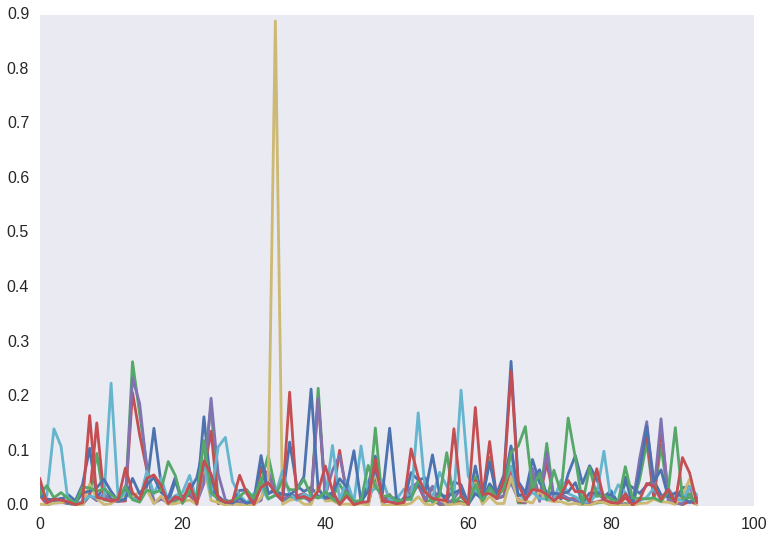

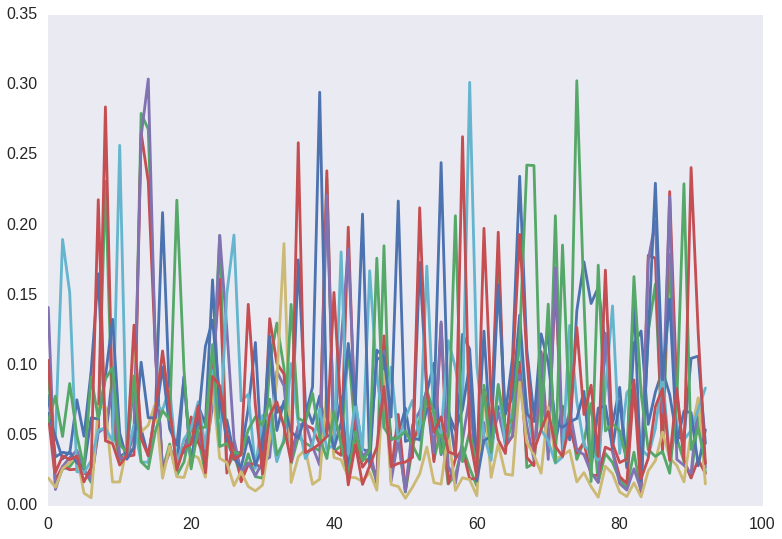

In [44]:
np.mean(train[:, 0])
cat_means = np.zeros([93, 9])
cat_stds = np.zeros([93, 9])

for i in range(len(finals)-1):
    for j in range(93):
        cat_means[j,i]= np.mean(train[finals[i]:finals[i+1],j])
        cat_stds[j,i]= np.std(train[finals[i]:finals[i+1],j])

plt.plot(cat_means, '-');

plt.figure()
plt.plot(cat_stds, '-');

In [59]:
np.shape(cat_means)

(93, 9)

In [110]:
cat_means[:,0]
np.shape(cat_stds[:,0])
# np.shape(train[0])

def plot_zscores(rel_class):
#     z_scores_good = np.zeros(93)
#     z_scores_bad = np.zeros(93)

    z_scores_means_1 = np.zeros(len(train))


#     for i in range(93):
#         z_scores_good[i] = (train[0,i]-cat_means[i,0])/cat_stds[i,0]
#         z_scores_bad[i] = (train[7000,i]-cat_means[i,0])/cat_stds[i,0]

    z_scores_buff = np.zeros(93)

    for j in range(len(train)):
        for i in range(93):
            z_scores_buff[i] = (train[j,i]-cat_means[i,rel_class])/cat_stds[i,rel_class]
        z_scores_means_1[j] = np.mean(np.abs(z_scores_buff))

    plt.plot(z_scores_means_1, '.')

    for i in finals:
        plt.plot([i,i], [0,1.5], 'r')

    plt.title("z-scores (re: Class_{})".format(rel_class+1))
    plt.xlabel("datapoint")

In [38]:
z_scores_tot = np.zeros(len(train_pca))
z_scores_buff = np.zeros(93+30)
tot_mean = np.mean(train_pca, 0)
tot_std = np.mean(train_pca, 0)

for j in range(len(train_pca)):
    for i in range(143):
        z_scores_buff[i] = (train[j,i]-tot_mean[i])/tot_std[i]
    z_scores_tot[j] = np.mean(np.abs(z_scores_buff))

IndexError: index 93 is out of bounds for axis 1 with size 93

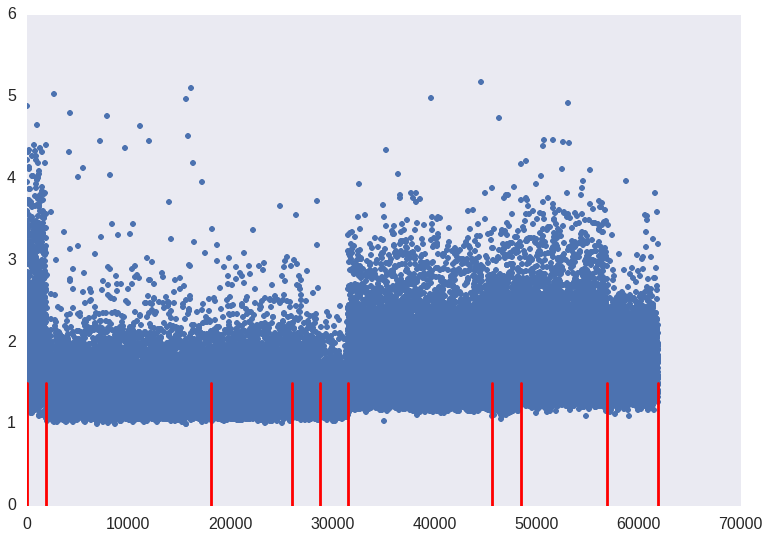

In [119]:
plt.plot(z_scores_tot, '.')

for i in finals:
    plt.plot([i,i], [0,1.5], 'r')

In [123]:
def indices(a, func):
    return [i for (i, val) in enumerate(a) if func(val)]

inds = indices(z_scores_tot, lambda x: x > 2)

In [43]:
np.shape(train_pca)

(61878, 143)

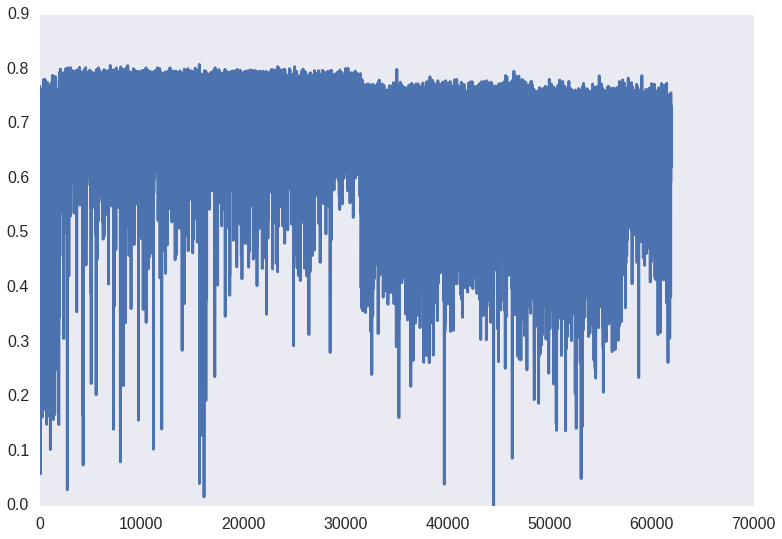

In [6]:
plt.plot(1-(z_scores_tot/np.max(z_scores_tot)))

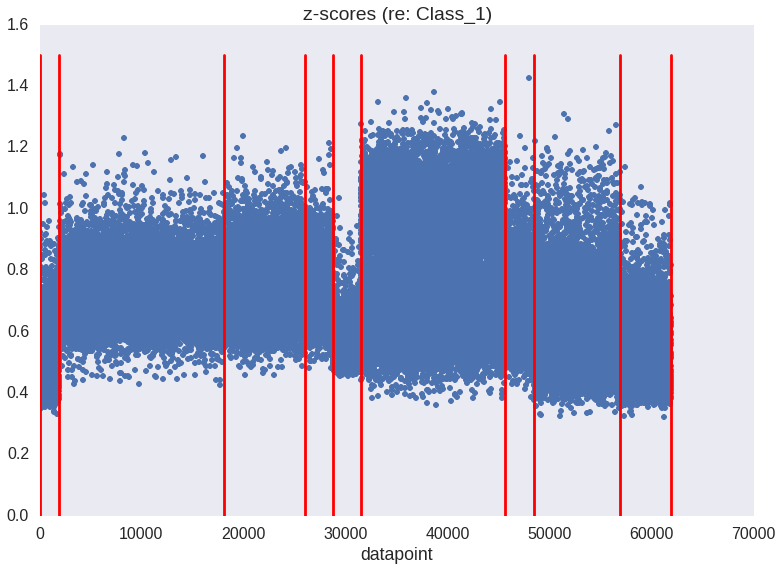

In [104]:
plot_zscores(0)

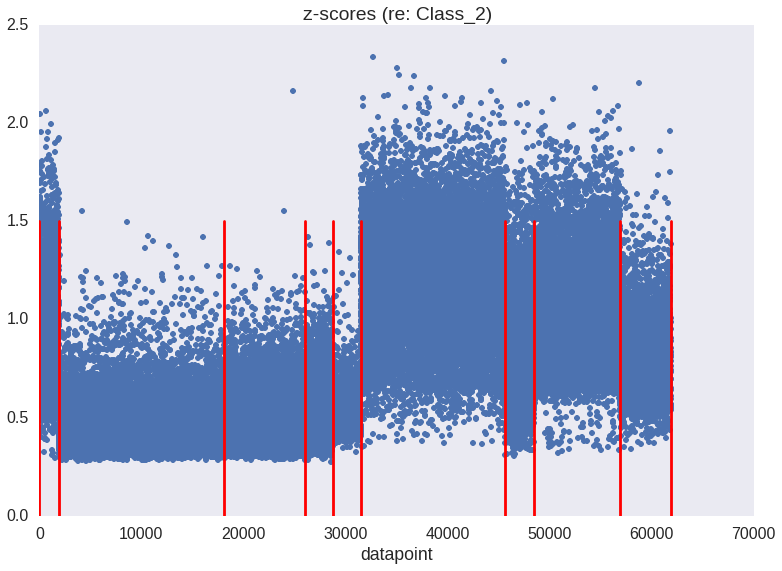

In [105]:
plot_zscores(1)

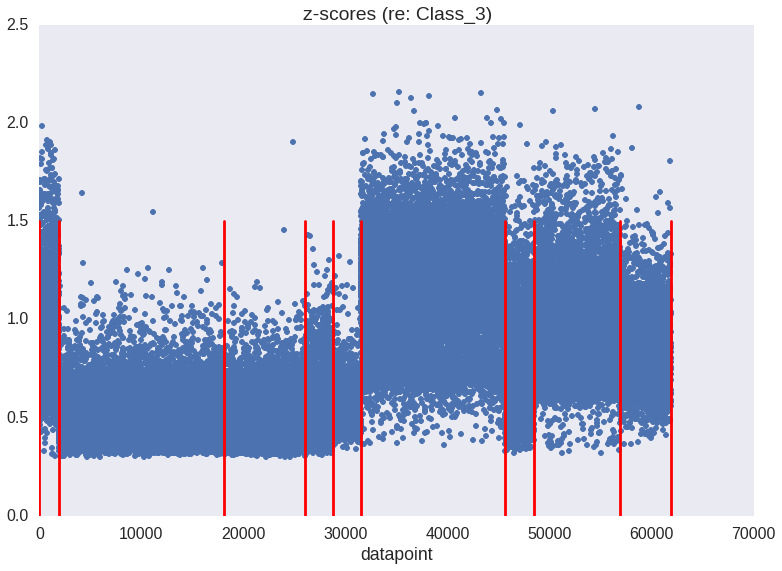

In [106]:
plot_zscores(2)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train, labels, train_size=0.95)



In [377]:
kde_0 = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(train[0:1928,:])
kde_1 = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(train[1929:18050,:])
kde_2 = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(train[18051:26054,:])
kde_3 = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(train[26055:28745,:])
kde_4 = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(train[28746:31484,:])
kde_5 = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(train[31485:45619,:])
kde_6 = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(train[45620:48458,:]) #45620
kde_7 = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(train[48459:56922,:])
kde_8 = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(train[56923:61877,:])

kdes = [kde_0, kde_1, kde_2, kde_3, kde_4, kde_5, kde_6, kde_7, kde_8]

In [343]:
X = train_df.values.copy()
X_train, X_valid, y_train, y_valid = train_test_split(train, labels, train_size=0.95)

def make_kdes(train, labels):
    for i in range(9):
        ix = labels == 'Class_{}'.format(i+1)
#         print('Class_{}'.format(i+1))
        kdes[i] = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(train[ix])

make_kdes(X_train, y_train)

ix = y_valid == 'Class_1'
y_valid[0]

'Class_8'

In [344]:
prob_array = np.zeros([len(X_valid), 9])
valid_probs = 0

for ix in range(10): # len(X_valid)
    y = X_valid[ix,:]

    for i in range(9):
        probs[i] = np.exp(kdes[i].score_samples(y))[0]
    index, value = max(enumerate(probs), key=operator.itemgetter(1))
    print(index, y_valid[ix])
    
    prob_array[ix,:] = probs/sum(probs)

prob_array[1]

7 Class_8
3 Class_3
0 Class_8
1 Class_2
0 Class_9
5 Class_6
3 Class_4
2 Class_3
3 Class_2
2 Class_2


array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.])

In [304]:
X = train_df.values.copy()
X_train, X_valid, y_train, y_valid = train_test_split(X[:, 1:-1], X[:, -1], train_size=0.8)

np.shape(y_train)

np.shape(X_train[y_train=="Class_2"])
y_train

array(['Class_2', 'Class_8', 'Class_3', ..., 'Class_8', 'Class_6',
       'Class_9'], dtype=object)

In [378]:
for ix in range(45620, 45650):
#     n = int(rand()*61877)
    n = ix

    probs = np.zeros(9)
    y = train[n,:]

    for i in range(9):
        probs[i] = np.exp(kdes[i].score_samples(y))[0]
    index, value = max(enumerate(probs), key=operator.itemgetter(1))
    
    print(index, labels[n])

probs = probs/max(probs)
probs

6 6
6 6
6 6
6 6
6 6
6 6
6 6
6 6
6 6
6 6
6 6
6 6
6 6
6 6
6 6
6 6
6 6
6 6
6 6
6 6
6 6
6 6
6 6
6 6
6 6
6 6
6 6
6 6
6 6
6 6


array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.95713380e-51,   0.00000000e+00,   0.00000000e+00,
         1.00000000e+00,   0.00000000e+00,   0.00000000e+00])

In [353]:
prob_array = np.zeros([len(test),9])

for ix in range(len(test)):
    y = test[ix,:]

    for i in range(9):
        probs[i] = np.exp(kdes[i].score_samples(y))[0]
    
    if ix % 10000 == 0: print(ix)
        
    prob_array[ix,:] = probs/sum(probs)


0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000


In [380]:
# for ix in range(len(test)):
y = test[61,:]

for i in range(9):
    probs[i] = np.exp(kdes[i].score_samples(y))*1e100

probs

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [354]:
# create submission file
preds = pd.DataFrame(prob_array, index=sample.id.values, columns=sample.columns[1:])
preds.to_csv('kde.csv', index_label='id')

In [384]:
preds.replace('NaN', 0, inplace=True)
preds.to_csv('kde.csv', index_label='id')

In [190]:
a = rand(5)

index, value = max(enumerate(a), key=operator.itemgetter(1))
print(a, index)

[ 0.13089253  0.22684188  0.1868485   0.08850243  0.65517935] 4


3.974695779886895e+145

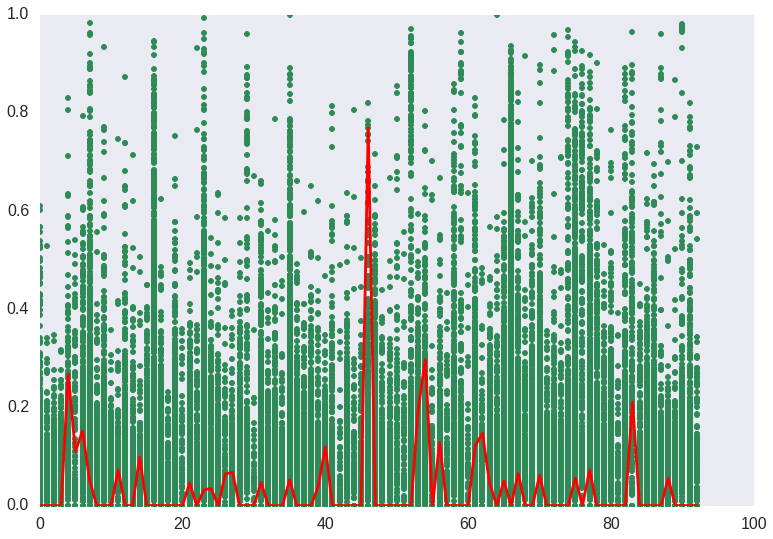

In [147]:
from sklearn.neighbors import KernelDensity

# array = np.reshape(train[:,1], [61878,1])
# np.shape(train[:,1])

X = array

y = train[50,:]

kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(X)

plt.plot(X.T, '.', c="seagreen")
plt.plot(y, 'r')

np.exp(kde.score_samples(y))[0]

3.9746957798866693e+145

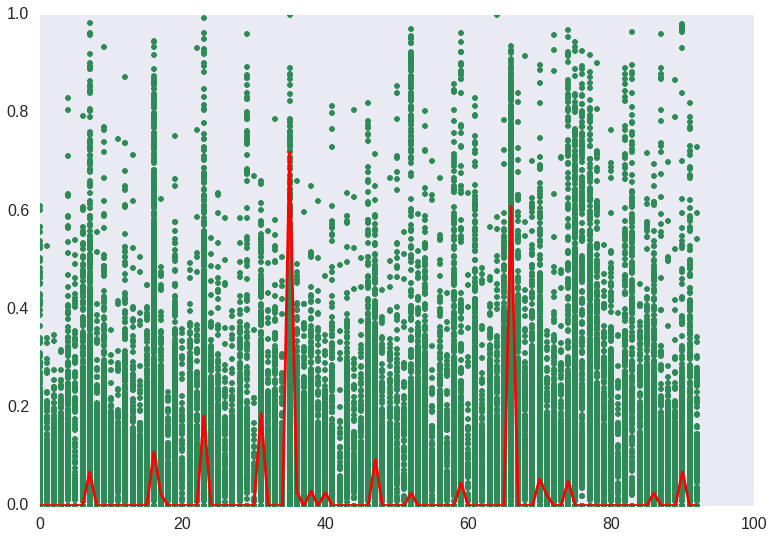

In [93]:
y = train[125,:]
plt.plot(X.T, '.', c="seagreen")
plt.plot(y, 'r')

np.exp(kde.score_samples(y))[0]

In [99]:
for i in range(5):
    n = int(rand()*61878)
    y = train[n,:]
    
    print(n, " ", labels[n], " ", np.exp(kde.score_samples(y))[0])

51483   7   8.14329071057e+103
10699   1   1.25790119295e+133
26489   3   14622608417.6
39669   5   3.13291650524e+132
51056   7   0.0


In [46]:
# plt.hist(array)

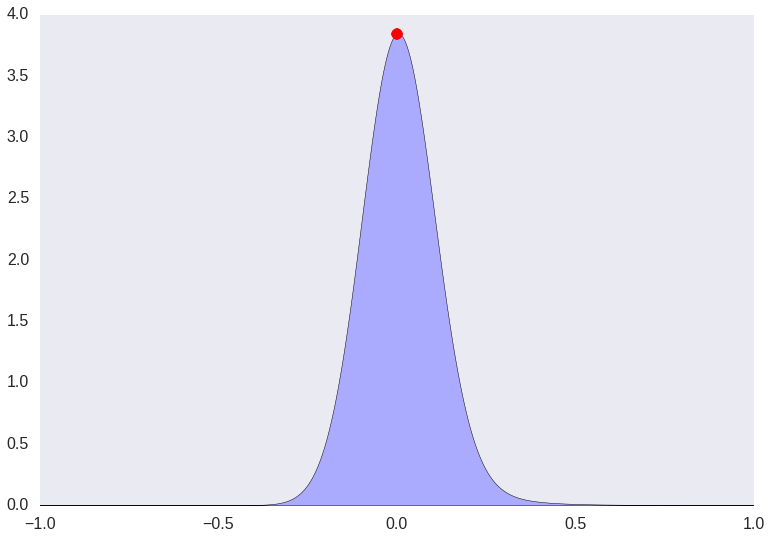

In [52]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(array)

X_plot = np.linspace(-1, 1, 1000)[:, np.newaxis]

log_dens = kde.score_samples(X_plot)
plt.fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')

plt.plot(0, np.exp(kde.score_samples(0)), 'or')

In [53]:
np.exp(kde.score_samples(0))

array([ 3.83815866])

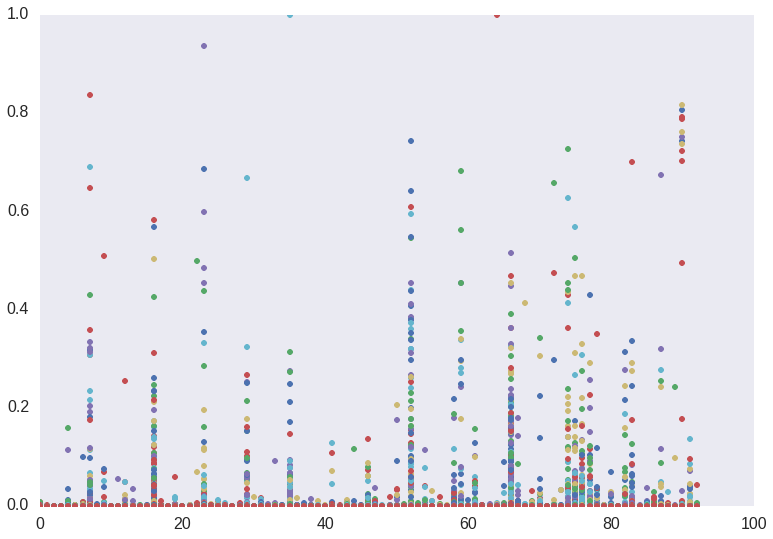

In [99]:
s = np.zeros([2, 93])
for i in range(1929):
    plt.plot(train[i,:]**10, '.');
    s[0] = s[0] + train[i, :]

In [7]:
sns.kdetrain[0]

array([ 0.08043636,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.06650619,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.16236491,  0.        ,  0.        ,  0.        ,
        0.        ,  0.06011209,  0.        ,  0.16658047,  0.0457056 ,
        0.07465443,  0.        ,  0.        ,  0.18084675,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.0721913 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.05051028,
        0.        ,  0.32651383,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.09289899,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.0514917 ,  0.        ,
        0.        ,  0.16778508,  0.        ,  0.        ,  0.75947136,
        0.        ,  0.05340311,  0.09619382,  0.        ,  0.08405275,
        0.        ,  0.30115857,  0.        ,  0.        ,  0.  

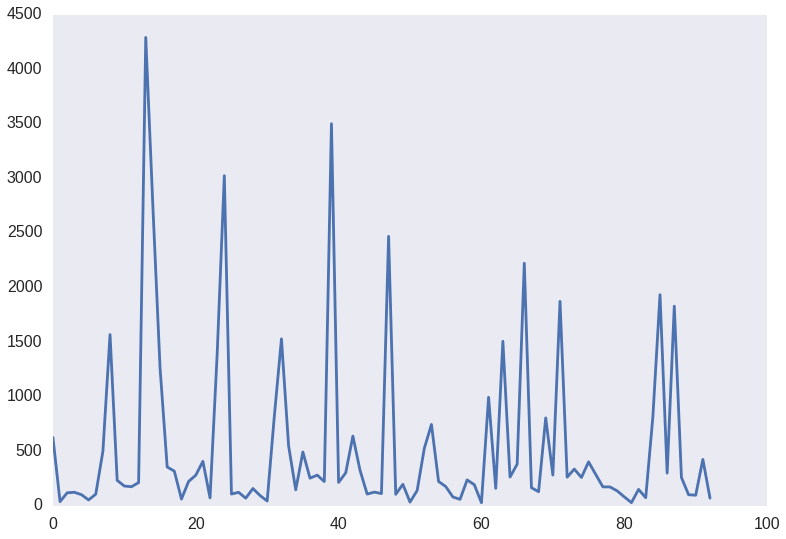

In [91]:
plt.plot(s_1)

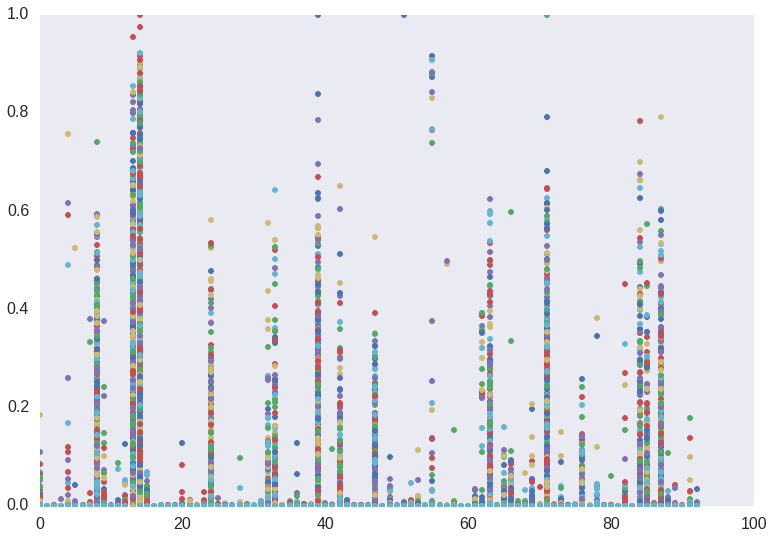

In [100]:
for i in range(1929, 18051):
    s[1] = s[1] + train[i, :]

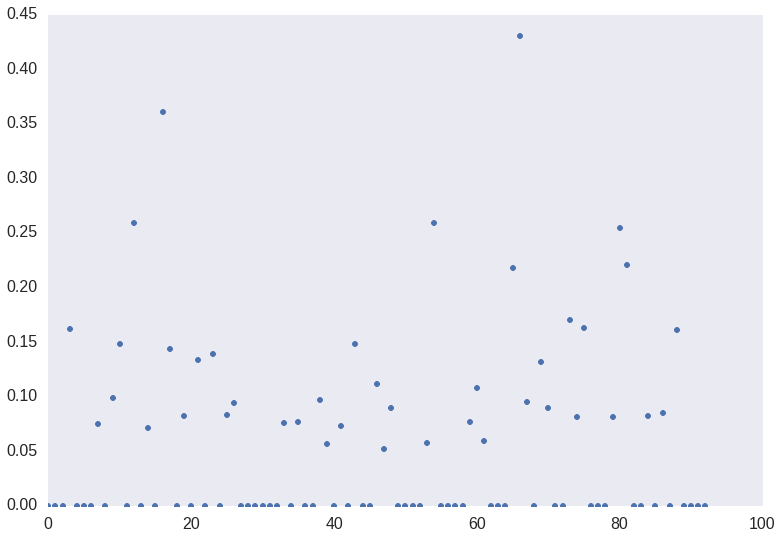

In [6]:
plt.plot(train[15], '.')

In [20]:
# train a random forest classifier
clf = ensemble.RandomForestClassifier(n_jobs=-1, n_estimators=1000)
clf.fit(train, labels)

# predict on test set
preds = clf.predict_proba(test)

In [12]:
preds

array([[ 0.003,  0.208,  0.254, ...,  0.04 ,  0.016,  0.01 ],
       [ 0.01 ,  0.02 ,  0.009, ...,  0.015,  0.22 ,  0.013],
       [ 0.001,  0.001,  0.001, ...,  0.003,  0.006,  0.   ],
       ..., 
       [ 0.004,  0.348,  0.41 , ...,  0.027,  0.008,  0.003],
       [ 0.002,  0.606,  0.131, ...,  0.006,  0.001,  0.001],
       [ 0.002,  0.471,  0.377, ...,  0.05 ,  0.007,  0.002]])

In [13]:
# create submission file
preds = pd.DataFrame(preds, index=sample.id.values, columns=sample.columns[1:])
preds.to_csv('random_new_1K.csv', index_label='id')

In [4]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=13, algorithm='auto')

knn.fit(train, labels)
print("fitting done...")

fitting done...


In [5]:
scores = cross_validation.cross_val_score(knn, train, labels, cv=2, n_jobs=-1)
print("average score: ", np.mean(scores))

average score:  0.775154451365


In [34]:
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

def logloss_mc(y_true, y_prob, epsilon=1e-15):
    """ Multiclass logloss
    This function is not officially provided by Kaggle, so there is no
    guarantee for its correctness.
    """
    # normalize
    y_prob = y_prob / y_prob.sum(axis=1).reshape(-1, 1)
    y_prob = np.maximum(epsilon, y_prob)
    y_prob = np.minimum(1 - epsilon, y_prob)
    # get probabilities
    y = [y_prob[i, j] for (i, j) in enumerate(y_true)]
    ll = - np.mean(np.log(y))
    return ll

X_train, X_valid, y_train, y_valid = train_test_split(train, labels, train_size=0.8)
y_prob = clf.predict_proba(X_valid)

encoder = LabelEncoder()
y_true = encoder.fit_transform(y_valid)

score = logloss_mc(y_true, y_prob)
score

0.14858987770818435